In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df = pd.read_excel('Exchange rate.xlsx')

In [3]:
print(df.head())

        Date   Price    Open    High     Low  Volume  Change
0 2023-05-01  2.7452  2.7078  2.7467  2.6924     NaN  0.0133
1 2023-04-01  2.7090  2.7169  2.7608  2.6863     NaN -0.0029
2 2023-03-01  2.7169  2.6925  2.7192  2.6493     NaN  0.0097
3 2023-02-01  2.6908  2.7607  2.7697  2.6876     NaN -0.0251
4 2023-01-01  2.7600  2.7102  2.7622  2.6835     NaN  0.0187


In [4]:
# Trying to find the missing values and handle them if necessary
print("Missing values in the dataset:")
print(df.isnull().sum())

Missing values in the dataset:
Date        0
Price       0
Open        0
High        0
Low         0
Volume    317
Change      0
dtype: int64


In [5]:
columns_to_drop = ['Volume','Open','High','Low','Change']

# Drop the specified columns that aren't necessary
df = df.drop(columns=columns_to_drop)

In [6]:
# The dataset has a 'Date' column, convert it to a datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
# Set 'Date' as the index
df.set_index('Date', inplace=True)

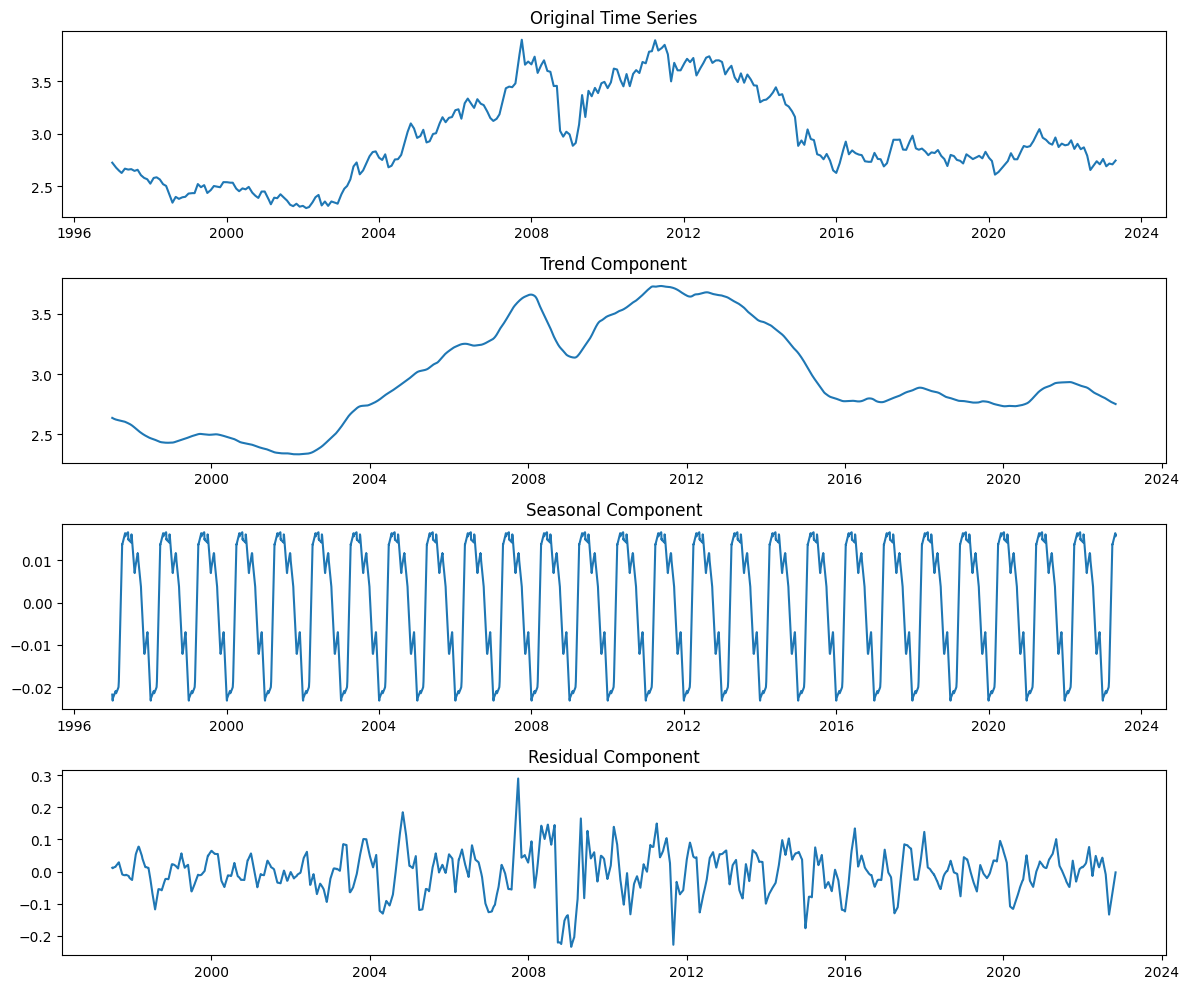

In [8]:
# Resample the time series data to a daily frequency
df_resampled = df.resample('D').mean()

# Handle missing values after resampling using linear interpolation
df_resampled['Price'] = df_resampled['Price'].interpolate(method='linear')

# Decompose the time series into trend, seasonality, and residual components
result = seasonal_decompose(df_resampled['Price'], model='additive', period=365)

# Visualize the components
plt.figure(figsize=(12, 10))

# Original time series
plt.subplot(4, 1, 1)
plt.plot(df_resampled['Price'])
plt.title('Original Time Series')

# Trend component
plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title('Trend Component')

# Seasonal component
plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title('Seasonal Component')

# Residual component
plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title('Residual Component')

plt.tight_layout()
plt.show()


C:\Users\LENIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error: 0.01
Root Mean Squared Error: 0.09


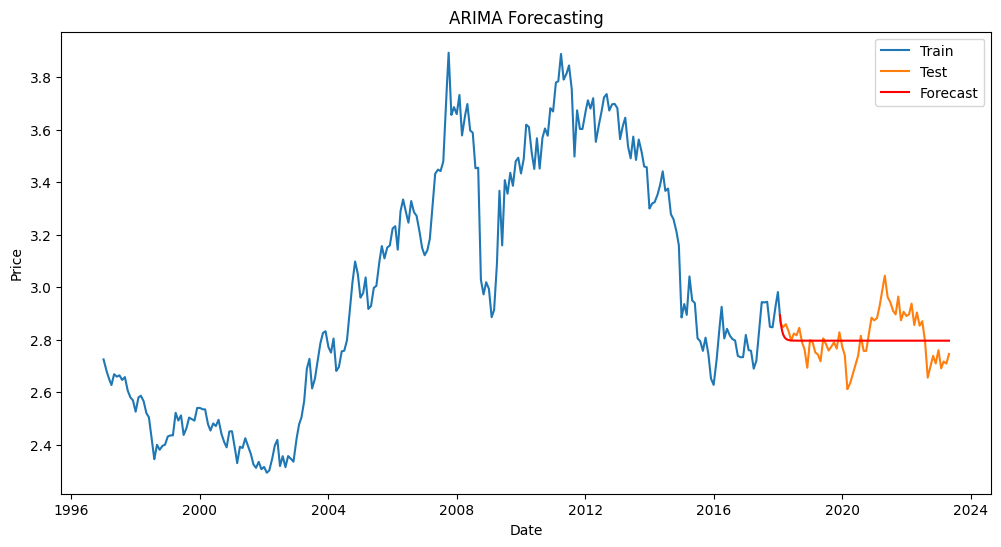

In [9]:
# Split the data into training and testing sets
train_size = int(len(df_resampled) * 0.8)
train, test = df_resampled[:train_size], df_resampled[train_size:]

# Fit an ARIMA model
model = ARIMA(train['Price'], order=(1, 1, 1))  # Adjust order as needed
fit_model = model.fit()

# Forecast future values
forecast_steps = len(test)
forecast = fit_model.get_forecast(steps=forecast_steps).predicted_mean

# Evaluate the model
mse = mean_squared_error(test['Price'], forecast)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')


plt.figure(figsize=(12, 6))
plt.plot(train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/50
241/241 [==============================] - 8s 12ms/step - loss: 0.0062
Epoch 2/50
241/241 [==============================] - 3s 11ms/step - loss: 9.2638e-05
Epoch 3/50
241/241 [==============================] - 3s 11ms/step - loss: 9.2498e-05
Epoch 4/50
241/241 [==============================] - 3s 11ms/step - loss: 9.1026e-05
Epoch 5/50
241/241 [==============================] - 3s 11ms/step - loss: 8.8952e-05
Epoch 6/50
241/241 [==============================] - 3s 11ms/step - loss: 9.6513e-05
Epoch 7/50
241/241 [==============================] - 3s 11ms/step - loss: 8.4797e-05
Epoch 8/50
241/241 [==============================] - 3s 11ms/step - loss: 8.5370e-05
Epoch 9/50
241/241 [==============================] - 3s 11ms/step - loss: 9.3166e-05
Epoch 10/50
241/241 [==============================] - 3s 11ms/step - loss: 8.2247e-05
Epoch 11/50
241/241 [==============================] - 3s 11ms/step - loss: 7.8421e-05
Epoch 12/50
241/241 [==============================] - 3

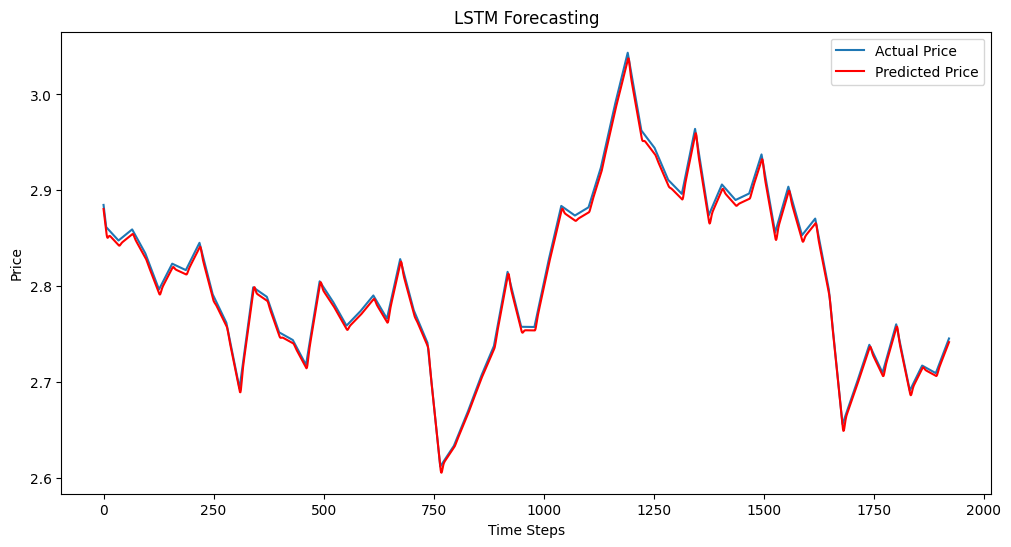

In [10]:
# Extract 'Price' column and normalize values
price_data = df_resampled['Price'].values.reshape(-1, 1)
scaler = MinMaxScaler()
price_data_scaled = scaler.fit_transform(price_data)

# Function to create time series sequences
def create_sequences(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        Y.append(data[i + seq_length, 0])
    return np.array(X), np.array(Y)

# Set sequence length
sequence_length = 10  # You can adjust this based on your data

# Create sequences
X, Y = create_sequences(price_data_scaled, sequence_length)

# Reshape data for LSTM input (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, Y_train = X[:train_size], Y[:train_size]
X_test, Y_test = X[train_size:], Y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=32)

# Make predictions on the test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

# Inverse transform the actual values for comparison
Y_test = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(Y_test)


plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual Price')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title('LSTM Forecasting')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()


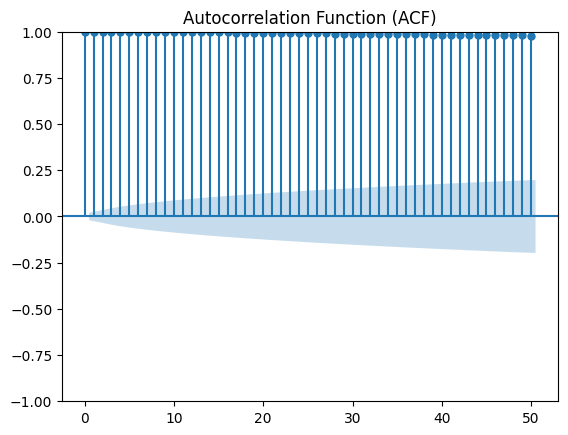

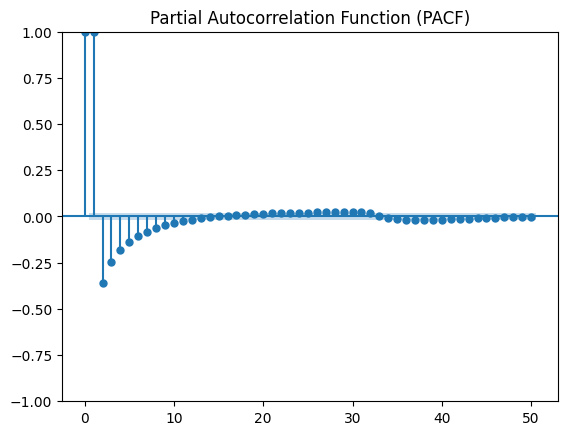

KeyboardInterrupt: 

In [12]:
df_resampled = df_resampled.resample('D').mean()

# Handle missing values after resampling using linear interpolation
df_resampled['Price'] = df_resampled['Price'].interpolate(method='linear')

# Visualize the autocorrelation and partial autocorrelation functions
plot_acf(df_resampled['Price'], lags=50, title='Autocorrelation Function (ACF)')
plot_pacf(df_resampled['Price'], lags=50, title='Partial Autocorrelation Function (PACF)')
plt.show()

# Fit SARIMA model
order = (1, 1, 1)  # (p, d, q) for the non-seasonal part
seasonal_order = (1, 1, 1, 365)  # (P, D, Q, s) for the seasonal part

# Create and fit the SARIMA model
sarima_model = SARIMAX(df_resampled['Price'], order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

# Forecast future values
forecast_steps = 365  # Adjust as needed
forecast = sarima_results.get_forecast(steps=forecast_steps)


plt.figure(figsize=(12, 6))
plt.plot(df_resampled['Price'], label='Actual')
plt.plot(forecast.predicted_mean, label='Forecast', color='red')
plt.fill_between(forecast.index, forecast.conf_int()['lower Price'], forecast.conf_int()['upper Price'], color='pink', alpha=0.3)
plt.title('SARIMA Forecasting')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
